In [1]:
# importing the libraries
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

In [2]:
df = pd.read_csv("songsDataset.csv",
                 encoding="utf-8",
                 header=0, 
                 names=["user_id","song_id","rating"])

# songs filtering
Since we have more than 100 000 songs,there are surely ones that have been rated few times and therefore they'll not be useful for our recommendation system. Let's get rid.<br>

In [3]:
song_rated_time = (df.
     groupby(by = ['song_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'freq'})
     [['song_id', 'freq']]
    )
song_rated_time.head(10)


,song_id,freq
0,0,5
1,1,2
2,2,4
3,3,18
4,4,2
5,6,2
6,7,9
7,8,4
8,9,4
9,10,2


We are going to select songs based on the frequency, the question that emerges is how to choose the **threshold** for which we will decide wether to keep the song or not. Let's perform some basic statistics in the **frequency column** to help us in our decision.

In [6]:
song_rated_time['freq'].describe()

count    127771.000000
mean         15.653004
std          54.576728
min           1.000000
25%           2.000000
50%           5.000000
75%          10.000000
max        1904.000000
Name: freq, dtype: float64

In [149]:
song_rated_time['freq'].quantile(np.arange(.9, 1, .01))

0.90     26.0
0.91     29.0
0.92     33.0
0.93     38.0
0.94     44.8
0.95     53.0
0.96     66.0
0.97     87.0
0.98    127.6
0.99    222.0
Name: freq, dtype: float64

In [152]:
(4*len(df["song_id"].unique()))/100

5110.84

In [7]:
rating_times_threshold = 44
popular_songs_id = song_rated_time.query('freq >= @rating_times_threshold')
popular_songs_id.head(10)

,song_id,freq
11,12,48
33,37,78
61,66,163
64,69,413
87,94,46
100,107,110
120,128,50
132,142,72
144,155,51
152,163,56


In [8]:
new_df = df[df['song_id'].isin(popular_songs_id.song_id)]

new_df.head(10)
len(new_df['song_id'].unique())

#new_df.to_csv("new_cf_dataset.csv",encoding="utf-8",header=True,index=False)

7839

In [9]:
user_activity = (new_df.
     groupby(by = ['user_id'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'freq'})
     [['user_id', 'freq']]
    )
user_activity.head(10)

,user_id,freq
0,0,3
1,1,5
2,2,4
3,3,6
4,4,9
5,5,10
6,6,5
7,7,8
8,8,8
9,9,2


In [161]:
user_activity['freq'].describe()

count    194289.000000
mean          5.083268
std           2.336118
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          10.000000
Name: freq, dtype: float64

In [182]:
user_activity['freq'].quantile(np.arange(.9, 1, .01))

0.90     8.0
0.91     8.0
0.92     9.0
0.93     9.0
0.94     9.0
0.95     9.0
0.96     9.0
0.97     9.0
0.98    10.0
0.99    10.0
Name: freq, dtype: float64

In [181]:
(2*len(new_df["user_id"].unique()))/100

3885.78

In [10]:
active_threshold = 10
most_active_users = user_activity.query('freq >= @active_threshold')[:2500]
most_active_users.head(10)

,user_id,freq
5,5,10
66,66,10
95,96,10
102,103,10
107,109,10
108,110,10
129,131,10
145,147,10
187,190,10
249,254,10


In [11]:
new_df = new_df[new_df['user_id'].isin(most_active_users.user_id)]
new_df.head()

,user_id,song_id,rating
50,5,8063,2
51,5,24427,4
52,5,39231,3
53,5,95898,3
54,5,98571,3


In [12]:
wide_user_data = new_df.pivot(index = 'user_id', columns = 'song_id', values = 'rating').fillna(0)
wide_user_data_sparse = csr_matrix(wide_user_data.values)

In [204]:
import scipy.io as sio

In [205]:
sio.savemat('user_data_sparse.mat', {'data':wide_user_data_sparse})

## Clustering

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(wide_user_data)
    wcss.append(km.inertia_)

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

<Figure size 640x480 with 1 Axes>

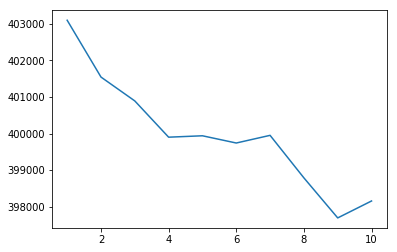

In [15]:
plt.plot(range(1,11),wcss)
plt.show()

In [17]:
wide_user_data.to_csv("user-item-data.csv")

In [19]:
X=pd.read_csv("user-item-data.csv",header=0)

In [22]:
cluster = KMeans(n_clusters= 4)

In [23]:
X['cluster'] = cluster.fit_predict(X)

In [29]:
len(X.query('cluster == 0'))

652

In [30]:
len(X.query('cluster == 1'))

636

In [31]:
len(X.query('cluster == 2'))

617

In [32]:
len(X.query('cluster == 3'))



595